# Reconciling Experts

This tutorial demonstrates how time dependent expert opinions can be reconciled in a Bayesian framework.

# Some Preliminaries

We can view the a time dependent expert opinion $x_i$ as a random walk process developing over time step $i$ such that

$$
x_{i+1} = x_i + \epsilon_i
$$

We will use the `ARIMA` package to model this time series in Pyro, but any other Pyro model can be used.

We start with some imports.

In [1]:
import torch
import pyro

import pyro.distributions
from pyro.nn import PyroModuleList, PyroModule, PyroSample
from ARIMA import BayesianARIMA

from matplotlib import pyplot as plt

Now let's define the model as a class.

In [2]:
class Model(PyroModule):
    def __init__(self, num_time_steps, num_series):
        super().__init__()
        self.time_series = PyroModuleList([
            BayesianARIMA(0, 1, 0, 0, 0, 0, 1,
                          o_tail_type='zero', # Use zero as the starting point
                          predict_idx=[*range(num_time_steps - 1)],
                          obs_idx=[num_time_steps - 1]) # We would like to observe the last value
                for count in range(num_series)])
        for time_series in self.time_series: # Set prior for the variance of the innovations
            time_series.innovations_dist.sigma = PyroSample(pyro.distributions.LogNormal(loc=0, scale=1))

    def forward(self):
        return torch.cat([time_series.predict()[..., None] for time_series in self.time_series], dim=-1)

The `Model` class supports multiple time series.

Below we create the model with two time series.

In [3]:
num_time_steps = 50
num_series = 2

model = Model(num_time_steps=num_time_steps, num_series=num_series)

As the model is Bayesian it has priors for all of its parameters and we can sample from it right away, even without any observations.

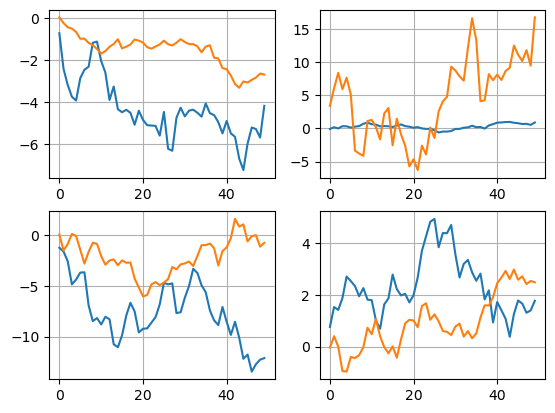

In [4]:
seed = 20240711
pyro.set_rng_seed(seed)
pyro.clear_param_store()

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(model().detach().numpy())
    plt.grid()

The two time series are independent and have different step variance. The model can be described by the directed graph shown below, where each node represents a random variable and the edges represent the dependencies between the random variables

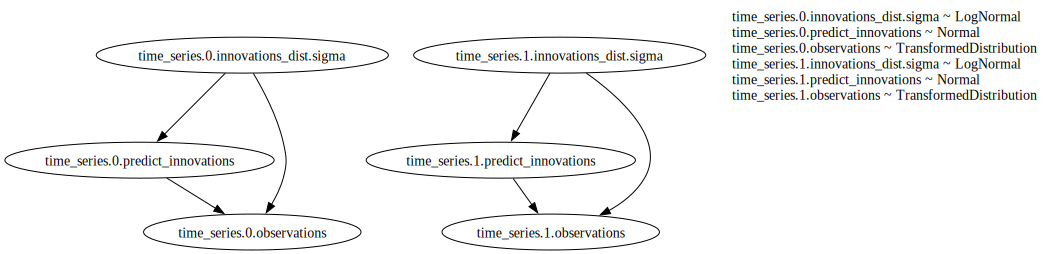

In [5]:
from ARIMA.pyro_utils import render_model

render_model(model)